In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

#%config InlineBackend.figure_format='retina'

In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

### Read data

In [3]:
pgrid_dir = "data/shared/pgrid_earth_gridtest_14"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [4]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)
endn = lg.load_netcdfs_end(cases)

# Configuration variables
cvars = lg.load_cvars(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Helpfiles: 100%|██████████| 96/96 [00:02<00:00, 46.51it/s]


Done


### Function to plot z vs x,y scatter graphs

In [5]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, 
             plot_scatter=True, plot_casenums=False, plot_controls=False,  
             logx=False,logy=False,logz=False, minz=None, maxz=None,
             interp='none', hatch_solid=False, symmetric=False):
    
    # Plotting parameters
    cm_key   = 'batlow' # color map name
    norm_lev = 10       # contour levels
    marker_e = 'none'   # scatter edge color
    marker_s = 170      # scatter size
    hatch_c  = 'white'  # hatch color
    hatch_t  = '/'      # hatch type
    hatch_w  = 1.5      # hatch line width
    h_thresh = 0.006    # hatch threshold for phi_global

    # Check params
    if symmetric and logz:
        print("WARNING: Cannot do symmetric colour-mapping with log-norm")
        return

    # Gather the data
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable 
    z_plt = np.array([], dtype=float) # z variable
    h_plt = np.array([], dtype=float) # hatch variable (i.e. melt fraction)
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        z_plt = np.append(z_plt, z[i])
        h_plt = np.append(h_plt, lg.access_hvars(hvars, "Phi_global", -1)[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return
    b_plt = np.invert(g_plt)
    
    # Do interpolation on z-variable
    interp_npts = 1000
    interp = interp.lower().strip()
    do_interp = interp in ['contour', 'mesh']
    if do_interp:
        marker_e='white'
        x_inp = sorted(list(set(x_plt)))
        y_inp = sorted(list(set(y_plt)))
        _,_,xxi,yyi,zzi = lg.interp_2d(x_inp,y_inp,z_plt, interp_npts, method='linear')

    # Hatch solid cases (if allowing interpolation)
    hatch_solid = hatch_solid and do_interp
    if hatch_solid:
        _,_,_,_,hhi = lg.interp_2d(x_inp,y_inp,h_plt, interp_npts, method='linear')
    
    # Colour mapping
    if minz == None:
        minz = np.amin(z_plt)
    if maxz == None:
        maxz = np.amax(z_plt)
    if minz > maxz:
        minz, maxz = maxz, minz
    if not logz:
        if symmetric:
            maxz = max(maxz, abs(minz))
            minz = -1.0 * maxz
            cm_key = 'vanimo'
        norm = mpl.colors.Normalize(vmin=minz, vmax=maxz)
    else:
        norm = mpl.colors.LogNorm(vmin=minz, vmax=maxz)
    cmap = sci_colormaps[cm_key]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cm = sm # mappable for colorbar

    # Make the plot
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    #    plot interpolation
    if do_interp:
        match interp:
            case 'contour':
                cm = ax.contourf(xxi,yyi,zzi, cmap=cmap, norm=norm, levels=norm_lev)
            case 'mesh':
                ax.pcolormesh(xxi,yyi,zzi, cmap=cmap, norm=norm)

    #    plot hatches
    if hatch_solid:
        mpl.rcParams['hatch.linewidth'] = hatch_w
        mpl.rcParams['hatch.color'] = hatch_c
        if np.any(hhi <= h_thresh):
            ax.contourf(xxi,yyi,hhi, alpha=0.0, levels=[-1,h_thresh,1],hatches=[hatch_t,''], zorder=3, extend='upper')
            ax.contour( xxi,yyi,hhi, alpha=1.0, levels=[-1,h_thresh,1],colors=[hatch_c]*3, zorder=3, extend='upper',linewidths=[hatch_w]*3)
    
    #    plot the raw values
    if plot_scatter:
        ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=cmap, marker='s', s=marker_s, edgecolors=marker_e, zorder=4)
        ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=cmap, marker='o', s=marker_s, edgecolors=marker_e, zorder=4)

    #    plot case numbers (debugging)
    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center', zorder=10)

    #    plot control variable text box (debugging)
    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, zorder=12,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    #    finalise
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cm, cax=cax, orientation='vertical').set_label(z_lbl) 

    return fig,ax

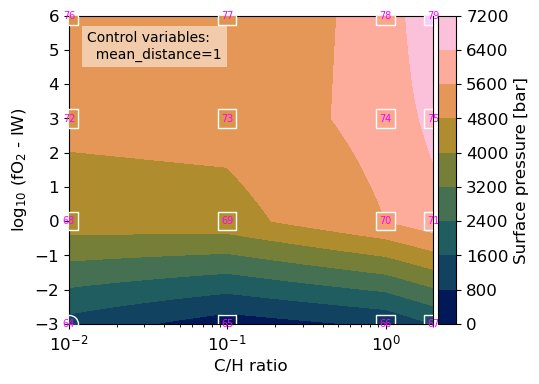

In [9]:
x = cvars["CH_ratio"];      x_lbl = "C/H ratio";    logx = True
# x = cvars["mean_distance"];   x_lbl = "Separation [AU]"; logx= True

y = cvars["fO2_shift_IW"];  y_lbl = "log$_{10}$ (fO$_{2}$ - IW)"; logy = False 

z = lg.access_hvars(hvars,"P_surf",-1); z_lbl = "Surface pressure [bar]"; logz=False
# z = lg.access_hvars(hvars,"Time",-1);  z_lbl = "Termination [Myr]"; logz=False
# z = lg.access_hvars(hvars,"H2O_mr",-1) * 100; z_lbl = "H2O VMR [%]"; logz=False
# z = np.array([ endn[i]["fl_U_LW"][0] for i in range(ncases) ]); z_lbl = "OLR [W m-2]"; logz=False
# z = np.array([ abs(endn[i]["fl_N"][0]-endn[i]["fl_N"][-1]) for i in range(ncases) ]); z_lbl = "Loss [W m-2]"; logz=False

control = {"mean_distance":1.0}

plot_controls = True
plot_casenums = True
plot_scatter  = True
interp        = 'contour'
hatch_solid   = False

make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, 
         plot_scatter=plot_scatter,plot_casenums=plot_casenums, plot_controls=plot_controls, 
         logx=logx, logy=logy, logz=logz, #minz=0, maxz=100,
         interp=interp, hatch_solid=hatch_solid, 
         )
plt.show()


### Function to plot z vs x using line graphs

In [7]:
def make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=False, logx=False, logz=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    x_mask = np.argsort(x_plt)
    x_srt = x_plt[x_mask]
    z_srt = z_plt[x_mask]

    ax.plot(x_srt, z_srt, color='k', lw=3, zorder=3)
    ax.scatter(x_srt, z_srt, marker='s', s=30, zorder=4)
    ax.scatter(x_plt[b_plt], z_plt[b_plt], marker='x', s=30, zorder=4)

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(z_lbl)
    if logz:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")

    return fig,ax



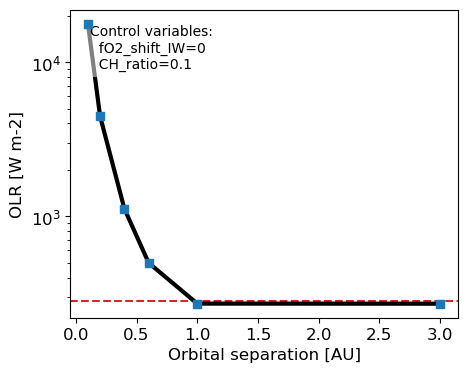

In [8]:
x = cvars["mean_distance"];  x_lbl = "Orbital separation [AU]"; logx = False
z = np.array([ endn[i]["fl_U_LW"][0] for i in range(ncases) ]); z_lbl = "OLR [W m-2]"
# z = endt * 1.0e-3; z_lbl = "Termination time [yr]"
control = {"fO2_shift_IW":0, "CH_ratio":0.1}

plot_controls = True
logz = True

fig,ax = make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=plot_controls, logx=logx, logz=logz)
ax.axhline(y=280, linestyle='dashed',zorder=2, label="SN Limit", color='tab:red')
plt.show()

